### Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import csv
from tqdm import tqdm
from keras.backend import clear_session
import gc

from autoencoder import create_train_val_set_random, create_train_val_set, create_autoencoder,fit_autoencoder_custom, hyperparameter_tuning, optimize_latent_variables
from Jcb import calc_basis_matrix, Jcb
from plot_fun import subplot_results

from gen_rand_design import gen_rand_design_m  # custom function for generating random designs
from scipy.optimize import minimize
from cordex_discrete import cordex_discrete

### Problem parameters

In [11]:
run = 4
sub_x = 2
sub_y = 2
epochs = 1_000
num_designs = 1_000
patience_prc = 0.3
batch_size = 256
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [16]
n_b = [3]
scalars = 0
optimizer_parameters = {'learning_rate': 0.01}

### Set up

In [12]:
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
des_pure_train, des_pure_val,des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                                          n_x=nx,
                                                                                          scalars=scalars,
                                                                                          optimality=optimality,
                                                                                          J_cb=J_cb,
                                                                                          noise=0.9,
                                                                                          num_designs=num_designs,
                                                                                          min=-10,
                                                                                          max=10)

  1%|          | 1000/100000 [00:00<00:04, 21489.75it/s]


### Hyperparameter tuning

In [13]:
best_latent_dim, best_alpha = hyperparameter_tuning(des_pure_train=des_pure_train,
                                                    des_pure_val=des_pure_val,
                                                    nn_epochs=100,
                                                    n_calls=10,
                                                    run=run,
                                                    nx=nx,
                                                    J_cb=J_cb,
                                                    batch_size=batch_size,
                                                    optimizer_parameters=optimizer_parameters)
print(f'Best latent dimension: {best_latent_dim} \nBest alpha: {best_alpha}')

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/100
4/4 [==============================] - 1s 39ms/step - loss: 306457.0938 - val_loss: 4679.6548
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 4884.0957 - val_loss: 3189.1143
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 3065.2178 - val_loss: 2867.9238
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 2745.6409 - val_loss: 2572.0432
Epoch 5/100
4/4 [==============================] - 0s 7ms/step - loss: 2453.3425 - val_loss: 2304.5483
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 2192.7007 - val_loss: 2073.5054
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 1966.5878 - val_loss: 1856.4673
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 1756.0122 - val_loss: 1659.2574
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1566.1484 - val_loss: 1472.0353
Epoch 10

KeyboardInterrupt: 

In [14]:
best_latent_dim = 2
best_alpha = 1e-2

### Create and Train NN

In [20]:
# 22, 0.0001
autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                   latent_dim=best_latent_dim,
                                                   alpha=best_alpha)
autoencoder, encoder, decoder, history = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                encoder=encoder,
                                                                decoder=decoder,
                                                                train_data=des_pure_train,
                                                                val_data=des_pure_val,
                                                                epochs=epochs,
                                                                batch_size=batch_size,
                                                                patience=patience_prc*epochs,
                                                                m=run,
                                                                n=sum(nx),
                                                                J_cb=J_cb)

Epoch 1/1000
4/4 [==============================] - 1s 48ms/step - loss: 1407011.5000 - val_loss: 899496.8125
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 763445.3750 - val_loss: 443792.1562
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 374347.3125 - val_loss: 252233.2344
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 222076.1562 - val_loss: 166722.4531
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 150009.9375 - val_loss: 120163.5312
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 109261.7578 - val_loss: 90118.7109
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 82497.4062 - val_loss: 69313.2969
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 63721.0938 - val_loss: 54906.0898
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 50469.3359 - val_loss: 44104.3398
Epoch 10/1000
4/4 [==============

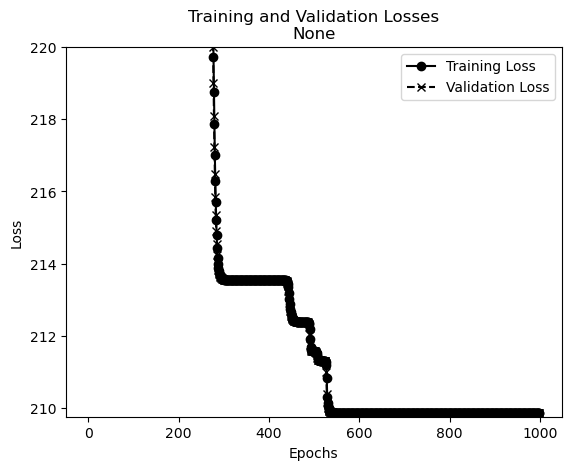

In [21]:
from autoencoder import plot_history
plot_history(history, threshold=220)

### Optimize latent space

In [22]:
optimal_latent_var, optimal_cr, optimal_des, bo_search, bo_evals = optimize_latent_variables(best_latent_dim=best_latent_dim,
                                                                                             decoder=decoder,
                                                                                             run=run,
                                                                                             nx=nx,
                                                                                             J_cb=J_cb,
                                                                                             n_calls=10)
# del autoencoder
# del encoder
# del decoder
# clear_session()
# gc.collect()

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 42ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0953
Function value obtained: 211.3670
Current minimum: 211.3670
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0230
Function value obtained: 210.6345
Current minimum: 210.6345
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 13ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0268
Function value obtained: 211.8895
Current minimum: 210.6345
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 10ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0256
Function value obtained: 209.8905
Current minimum: 209.8905
Itera

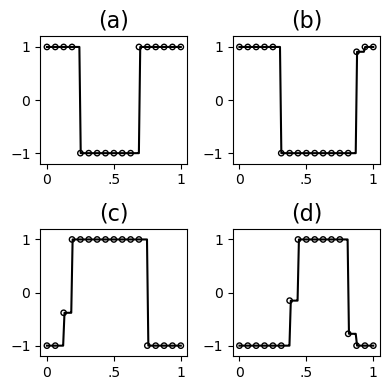

In [23]:
permutation_matrix = np.array([[0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [1, 0, 0, 0],
                               [0, 0, 0, 1]])

results = np.matmul(permutation_matrix, optimal_des)
figure = subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0, 1, 100), results=np.round(results, 3), show=False, size=15)

### 3D plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have the 'decoder' and 'objective_function' available from your code

# Create a grid in the latent space
latent_dim1_range = np.linspace(-1, 1, 50)  # Adjust the range and number of points as needed
latent_dim2_range = np.linspace(-1, 1, 50)  # Adjust the range and number of points as needed
latent_dim1_grid, latent_dim2_grid = np.meshgrid(latent_dim1_range, latent_dim2_range)

# Initialize an array to store the objective function values
objective_values = np.zeros_like(latent_dim1_grid)

# Evaluate the objective function for each point in the latent space grid
for i in range(latent_dim1_grid.shape[0]):
    for j in range(latent_dim1_grid.shape[1]):
        latent_point = np.array([[latent_dim1_grid[i, j], latent_dim2_grid[i, j]]])
        decoded_point = decoder.predict(latent_point).reshape(run, sum(nx))  # Use your decoder to get the original space
        Z = np.hstack((np.ones((run,1)), decoded_point @ J_cb))
        M = Z.T @ Z
        objective_values[i, j] =  np.trace(np.linalg.inv(M))

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Customizing the colormap
# We define a new colormap that doesn't include black
colors = [(0.5, 0.5, 0.5), (1, 1, 1)]  # Dark grey to white
n_bins = 100  # Increase this number to have a smoother transition
cmap_name = 'my_gray'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Add Bayesian Optimization points to the plot
bo_search = np.array(bo_search)
bo_evals = np.array(bo_evals)
ax.plot(bo_search[:, 0], bo_search[:, 1], bo_evals, color='black', marker='o', linestyle='dashed', zorder=4)

# Now plot the points, with an even larger zorder to make them appear on top
ax.scatter(bo_search[:, 0], bo_search[:, 1], bo_evals, color='black', s=50, zorder=4)

surf = ax.plot_surface(latent_dim1_grid, latent_dim2_grid, objective_values, cmap=cm)
# Labels and title
ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_zlabel('Objective Function')
ax.set_title('3D Visualization of Latent Space with Bayesian Optimization Steps')

# fig.set_size_inches(12, 8)  # You can adjust the size as needed
plt.savefig('trace.png', dpi=300)  # Save the figure at 300 DPI

plt.show()

1/1 [==============================] - 0s 12ms/step


### Loop

In [5]:
# Initialize a CSV file for storing the results
csv_filename = "results_simpleNN_manual.csv"
csv_header = ["Run", "nx", "Optimal CR", "Execution Time (s)", "Latent Dim", "Alpha", "Designs"]

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(csv_header)

In [6]:
              # 3              # 4              # 8              # 16             # 100
best_hyper = [[1, 1e-3, 5_000],[3, 1e-3, 1_000],[6, 1e-3, 1_000],[5, 1e-3, 1_000],[4, 1e-3, 1_000], # 4 # problem with Bayesian on 3rd
              [1, 1e-3, 1_000],[4, 1e-3, 1_000],[3, 1e-3, 1_000],[3, 1e-3, 1_000],[4, 1e-3, 1_000], # 8
              [1, 1e-3, 1_000],[1, 1e-3, 1_000],[1, 1e-1, 1_000],[3, 1e-3, 5_000],[1, 1e-3, 5_000]] # 12

N_scale = 12*100
fixed_lat = 6
fixed_alpha = 1e-3
fixed_data = 6_000

best_hyper_fixed = [fixed_lat, fixed_alpha, fixed_data]

runs = [4, 8, 12]
nx_s = [[3], [4], [8], [16], [100]]
n_b = [3]

In [7]:
total_iterations = len(runs) * len(nx_s)
pbar = tqdm(total=total_iterations, desc="Overall Progress")
count = 0
for run in runs:
    for nx in nx_s:
        hyper = best_hyper[count]
        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
        des_pure_train, des_pure_val,_, _ = create_train_val_set_random(runs=run,
                                                                        n_x=nx,
                                                                        scalars=scalars,
                                                                        optimality=optimality,
                                                                        J_cb=J_cb,
                                                                        noise=0.9,
                                                                        num_designs=hyper[2],
                                                                        epsilon=1e-10)
        hyper[0] = int(1+4*(np.log(1+des_pure_train.shape[1])/np.log(1+N_scale)))
        start = timer()

        autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                           latent_dim=hyper[0],
                                                           alpha=hyper[1],
                                                           base=2)
        autoencoder, encoder, decoder, _ = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                  encoder=encoder,
                                                                  decoder=decoder,
                                                                  train_data=des_pure_train,
                                                                  val_data=des_pure_val,
                                                                  epochs=epochs,
                                                                  batch_size=batch_size,
                                                                  patience=0.20*epochs,
                                                                  m=run,
                                                                  n=sum(nx),
                                                                  J_cb=J_cb)
        _, optimal_cr, _ = optimize_latent_variables(best_latent_dim=hyper[0],
                                                     decoder=decoder,
                                                     run=run,
                                                     nx=nx,
                                                     J_cb=J_cb,
                                                     acq_func='gp_hedge',
                                                     n_calls=hyper[0]*15)

        end = timer()
        del autoencoder
        del encoder
        del decoder
        clear_session()
        gc.collect()
        exec_time = timedelta(seconds=end - start).total_seconds()

        # Store the results in the CSV file
        with open(csv_filename, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([run, sum(nx), np.round(optimal_cr,3), exec_time, hyper[0], hyper[1], hyper[2]])
        pbar.update(1)
        count += 1
pbar.close()
print("DONE")

  5%|▌         | 5013/100000 [00:00<00:01, 91268.39it/s]

Epoch 1/1000



2023-12-08 17:32:07.012706: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 1s 8ms/step - loss: 407192.9688 - val_loss: 162214.8438
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 113116.3359 - val_loss: 72528.3906
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 56131.6367 - val_loss: 40094.4492
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 32000.0312 - val_loss: 23679.8711
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 19049.8242 - val_loss: 14576.8623
Epoch 6/1000
16/16 [==============================] - 0s 2ms/step - loss: 11746.7070 - val_loss: 9154.5469
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 7478.4551 - val_loss: 5962.0981
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 4902.1255 - val_loss: 3967.0208
Epoch 9/1000
16/16 [==============================] - 0s 2ms/step - loss: 3316.0437 - val_loss: 2738.6609
Epoch 10/1000
16/16 [========================

  1%|          | 1005/100000 [00:00<00:01, 71678.61it/s]

Epoch 1/1000


4/4 [==============================] - 0s 30ms/step - loss: 743357.3750 - val_loss: 323527.7500
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 296766.1875 - val_loss: 205100.9219
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 191277.6406 - val_loss: 152321.5625
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 142481.0625 - val_loss: 117326.2188
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 110705.0078 - val_loss: 94645.1016
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 88936.8906 - val_loss: 77697.3984
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 72623.9141 - val_loss: 65689.4219
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 61261.0469 - val_loss: 55145.7695
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 51579.1016 - val_loss: 47510.5039
Epoch 10/1000
4/4 [==============================

  1%|          | 1016/100000 [00:00<00:01, 75360.55it/s]

Epoch 1/1000


4/4 [==============================] - 1s 32ms/step - loss: 544294.0625 - val_loss: 233283.2031
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 212358.2812 - val_loss: 144409.2656
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 137864.3281 - val_loss: 104325.7188
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 101345.0000 - val_loss: 80368.5938
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 78740.3750 - val_loss: 63907.5859
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 62898.7969 - val_loss: 52808.4766
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 52072.9219 - val_loss: 44172.2500
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 43564.7891 - val_loss: 37294.8164
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 36756.7383 - val_loss: 31576.9199
Epoch 10/1000
4/4 [==============================] 

  1%|          | 1076/100000 [00:00<00:01, 75619.90it/s]

Epoch 1/1000


4/4 [==============================] - 1s 32ms/step - loss: 623665.2500 - val_loss: 194716.0625
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 160482.3594 - val_loss: 103681.0391
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 89986.8594 - val_loss: 69466.2109
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 61304.5938 - val_loss: 51085.1445
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 45492.8867 - val_loss: 39367.2812
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 35185.6016 - val_loss: 31340.2031
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 28067.3457 - val_loss: 25407.4648
Epoch 8/1000
4/4 [==============================] - 0s 6ms/step - loss: 22820.5000 - val_loss: 20827.7109
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 18747.4219 - val_loss: 17272.7324
Epoch 10/1000
4/4 [==============================] - 0

  2%|▏         | 2230/100000 [00:00<00:01, 88759.49it/s]

Epoch 1/1000


4/4 [==============================] - 1s 64ms/step - loss: 1593929.7500 - val_loss: 463253.8750
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 250526.0000 - val_loss: 67886.7969
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 54758.4766 - val_loss: 33788.5781
Epoch 4/1000
4/4 [==============================] - 0s 9ms/step - loss: 29328.8379 - val_loss: 21392.3730
Epoch 5/1000
4/4 [==============================] - 0s 10ms/step - loss: 19084.5664 - val_loss: 14710.4463
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 13321.9004 - val_loss: 10713.9326
Epoch 7/1000
4/4 [==============================] - 0s 9ms/step - loss: 9829.5508 - val_loss: 8125.3706
Epoch 8/1000
4/4 [==============================] - 0s 9ms/step - loss: 7518.3999 - val_loss: 6323.5439
Epoch 9/1000
4/4 [==============================] - 0s 8ms/step - loss: 5866.0225 - val_loss: 4921.4438
Epoch 10/1000
4/4 [==============================] - 0s 8m

  1%|          | 1000/100000 [00:00<00:01, 74643.70it/s]

Epoch 1/1000


4/4 [==============================] - 0s 31ms/step - loss: 867462.7500 - val_loss: 417909.7500
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 356442.3125 - val_loss: 256728.5469
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 229774.2344 - val_loss: 185483.2969
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 169600.1406 - val_loss: 142875.8594
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 132566.5156 - val_loss: 114930.4531
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 107511.7266 - val_loss: 94576.7734
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 89105.4531 - val_loss: 79691.1172
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 75289.1094 - val_loss: 68148.0234
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 64376.1484 - val_loss: 58538.1484
Epoch 10/1000
4/4 [============================

  1%|          | 1000/100000 [00:00<00:01, 80704.70it/s]

Epoch 1/1000


4/4 [==============================] - 1s 31ms/step - loss: 146299.6875 - val_loss: 58982.6094
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 50616.8242 - val_loss: 40166.8242
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 35665.9141 - val_loss: 30183.5469
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 27248.0000 - val_loss: 23937.0371
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 21820.6602 - val_loss: 19553.8770
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 17903.3516 - val_loss: 16328.6797
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 15015.2236 - val_loss: 13739.5928
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 12671.6709 - val_loss: 11636.4424
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 10768.8477 - val_loss: 9870.8535
Epoch 10/1000
4/4 [==============================] - 0s 5m

  1%|          | 1000/100000 [00:00<00:01, 75780.59it/s]

Epoch 1/1000


4/4 [==============================] - 1s 31ms/step - loss: 559634.5625 - val_loss: 138262.0156
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 124328.2812 - val_loss: 79427.5938
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 75486.9531 - val_loss: 55092.6562
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 53177.8398 - val_loss: 41260.7383
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 40053.0664 - val_loss: 31972.0527
Epoch 6/1000
4/4 [==============================] - 0s 6ms/step - loss: 31112.2578 - val_loss: 25363.7891
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 24683.0430 - val_loss: 20590.8203
Epoch 8/1000
4/4 [==============================] - 0s 6ms/step - loss: 20024.7070 - val_loss: 16885.6289
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 16392.3418 - val_loss: 13983.8320
Epoch 10/1000
4/4 [==============================] - 0s

  1%|          | 1000/100000 [00:00<00:01, 87145.31it/s]

Epoch 1/1000


4/4 [==============================] - 1s 34ms/step - loss: 1203311.0000 - val_loss: 338075.1875
Epoch 2/1000
4/4 [==============================] - 0s 6ms/step - loss: 233046.0938 - val_loss: 123215.1562
Epoch 3/1000
4/4 [==============================] - 0s 7ms/step - loss: 96953.1719 - val_loss: 64378.7305
Epoch 4/1000
4/4 [==============================] - 0s 7ms/step - loss: 56253.3242 - val_loss: 38712.9258
Epoch 5/1000
4/4 [==============================] - 0s 7ms/step - loss: 36333.6211 - val_loss: 25382.2227
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 24729.9844 - val_loss: 17389.4492
Epoch 7/1000
4/4 [==============================] - 0s 8ms/step - loss: 17591.7578 - val_loss: 13009.0898
Epoch 8/1000
4/4 [==============================] - 0s 6ms/step - loss: 13184.2529 - val_loss: 10158.2979
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 10277.0430 - val_loss: 8250.7891
Epoch 10/1000
4/4 [==============================] - 0

  1%|          | 1000/100000 [00:00<00:01, 59947.75it/s]


Epoch 1/1000
4/4 [==============================] - 2s 61ms/step - loss: 1339791.0000 - val_loss: 26492.0801
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 21122.1406 - val_loss: 12566.6123
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 10787.5303 - val_loss: 7506.4917
Epoch 4/1000
4/4 [==============================] - 0s 15ms/step - loss: 6625.3242 - val_loss: 5020.0425
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 4527.0796 - val_loss: 3603.4255
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 3280.5803 - val_loss: 2673.2085
Epoch 7/1000
4/4 [==============================] - 0s 14ms/step - loss: 2454.8494 - val_loss: 2054.4851
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 1894.9775 - val_loss: 1602.1373
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 1483.7655 - val_loss: 1270.7386
Epoch 10/1000
4/4 [=============================

  1%|          | 1000/100000 [00:00<00:01, 77310.08it/s]

Epoch 1/1000


4/4 [==============================] - 0s 32ms/step - loss: 10099.4434 - val_loss: 5369.9238
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 4678.3477 - val_loss: 3877.4851
Epoch 3/1000
4/4 [==============================] - 0s 6ms/step - loss: 3471.4512 - val_loss: 3023.0068
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 2743.3682 - val_loss: 2473.3818
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 2260.0073 - val_loss: 2059.5583
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 1892.8983 - val_loss: 1758.3403
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 1622.0601 - val_loss: 1514.9680
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 1400.6516 - val_loss: 1308.0590
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 1211.8385 - val_loss: 1128.2858
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 10

  1%|          | 1000/100000 [00:00<00:01, 72015.11it/s]

Epoch 1/1000


4/4 [==============================] - 1s 53ms/step - loss: 1497188.0000 - val_loss: 690506.3750
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 499600.6875 - val_loss: 228342.7188
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 198564.4375 - val_loss: 121942.3906
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 116334.6172 - val_loss: 78366.8516
Epoch 5/1000
4/4 [==============================] - 0s 7ms/step - loss: 77996.6875 - val_loss: 55309.4961
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 55107.5117 - val_loss: 40934.8711
Epoch 7/1000
4/4 [==============================] - 0s 7ms/step - loss: 41205.0664 - val_loss: 31427.9727
Epoch 8/1000
4/4 [==============================] - 0s 7ms/step - loss: 31814.1270 - val_loss: 25087.1992
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 25457.3652 - val_loss: 20218.0195
Epoch 10/1000
4/4 [=============================

  1%|          | 1000/100000 [00:00<00:01, 74738.13it/s]

Epoch 1/1000


4/4 [==============================] - 1s 61ms/step - loss: 889804.3750 - val_loss: 234599.7188
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 183420.5469 - val_loss: 106411.0625
Epoch 3/1000
4/4 [==============================] - 0s 9ms/step - loss: 89659.3906 - val_loss: 64123.6406
Epoch 4/1000
4/4 [==============================] - 0s 6ms/step - loss: 55073.2617 - val_loss: 43695.3281
Epoch 5/1000
4/4 [==============================] - 0s 8ms/step - loss: 37990.1836 - val_loss: 31548.5879
Epoch 6/1000
4/4 [==============================] - 0s 7ms/step - loss: 27705.0332 - val_loss: 23851.8652
Epoch 7/1000
4/4 [==============================] - 0s 7ms/step - loss: 21086.0508 - val_loss: 18303.9219
Epoch 8/1000
4/4 [==============================] - 0s 7ms/step - loss: 16281.6240 - val_loss: 14330.7227
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 12781.4990 - val_loss: 11436.3271
Epoch 10/1000
4/4 [==============================] - 0

  5%|▌         | 5000/100000 [00:00<00:01, 87266.43it/s]

Epoch 1/1000


16/16 [==============================] - 1s 13ms/step - loss: 424340.3438 - val_loss: 18048.0312
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 9845.1104 - val_loss: 4918.1250
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 3198.4075 - val_loss: 1944.4482
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 1331.2944 - val_loss: 845.1480
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 613.0215 - val_loss: 422.4667
Epoch 6/1000
16/16 [==============================] - 0s 4ms/step - loss: 321.9846 - val_loss: 235.6464
Epoch 7/1000
16/16 [==============================] - 0s 5ms/step - loss: 188.9653 - val_loss: 147.6442
Epoch 8/1000
16/16 [==============================] - 0s 5ms/step - loss: 124.8597 - val_loss: 104.2943
Epoch 9/1000
16/16 [==============================] - 0s 5ms/step - loss: 93.0681 - val_loss: 83.0305
Epoch 10/1000
16/16 [==============================] - 0s 5ms/step -

  5%|▌         | 5000/100000 [00:00<00:01, 53221.94it/s]


Epoch 1/1000
16/16 [==============================] - 2s 35ms/step - loss: 163903.0469 - val_loss: 1586.4330
Epoch 2/1000
16/16 [==============================] - 0s 22ms/step - loss: 987.6439 - val_loss: 567.6241
Epoch 3/1000
16/16 [==============================] - 0s 23ms/step - loss: 411.9014 - val_loss: 278.6961
Epoch 4/1000
16/16 [==============================] - 0s 23ms/step - loss: 216.0149 - val_loss: 159.3195
Epoch 5/1000
16/16 [==============================] - 0s 24ms/step - loss: 130.7676 - val_loss: 104.2691
Epoch 6/1000
16/16 [==============================] - 0s 24ms/step - loss: 90.3038 - val_loss: 78.0250
Epoch 7/1000
16/16 [==============================] - 0s 23ms/step - loss: 72.8154 - val_loss: 68.5311
Epoch 8/1000
16/16 [==============================] - 0s 24ms/step - loss: 66.9576 - val_loss: 65.7356
Epoch 9/1000
16/16 [==============================] - 0s 26ms/step - loss: 65.3230 - val_loss: 65.0053
Epoch 10/1000
16/16 [==============================] - 0s 2

Overall Progress: 100%|██████████| 15/15 [15:03<00:00, 60.25s/it] 

DONE


### Manual tuning

In [12]:
run = 12
sub_x = 2
sub_y = 2
epochs = 1_000
num_designs = 6_000
patience_prc = 0.05
batch_size = 512
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
nx = [100]
n_b = [3]
scalars = 0
optimizer_parameters = {'learning_rate': 1e-2}


latent_dim = 2
alpha = 1e-3


J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
des_pure_train, des_pure_val,des_noisy_train, des_noisy_val = create_train_val_set_random(runs=run,
                                                                                          n_x=nx,
                                                                                          scalars=scalars,
                                                                                          optimality=optimality,
                                                                                          J_cb=J_cb,
                                                                                          noise=0.9,
                                                                                          num_designs=num_designs,
                                                                                          epsilon=1e-10)

  5%|▌         | 5000/100000 [00:00<00:02, 46650.44it/s]


In [13]:
# 22, 0.0001
autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                   latent_dim=latent_dim,
                                                   alpha=alpha)
autoencoder, encoder, decoder, history = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                encoder=encoder,
                                                                decoder=decoder,
                                                                train_data=des_pure_train,
                                                                val_data=des_pure_val,
                                                                epochs=epochs,
                                                                batch_size=batch_size,
                                                                monitor='loss',
                                                                patience=patience_prc*epochs,
                                                                m=run,
                                                                n=sum(nx),
                                                                J_cb=J_cb)

Epoch 1/1000
8/8 [==============================] - 2s 57ms/step - loss: 565594.5625 - val_loss: 7118.4951
Epoch 2/1000
8/8 [==============================] - 0s 36ms/step - loss: 4615.5371 - val_loss: 2490.1226
Epoch 3/1000
8/8 [==============================] - 0s 39ms/step - loss: 1798.4658 - val_loss: 1133.7725
Epoch 4/1000
8/8 [==============================] - 0s 37ms/step - loss: 871.5964 - val_loss: 607.7738
Epoch 5/1000
8/8 [==============================] - 0s 38ms/step - loss: 490.5481 - val_loss: 363.5786
Epoch 6/1000
8/8 [==============================] - 0s 40ms/step - loss: 304.2831 - val_loss: 240.3707
Epoch 7/1000
8/8 [==============================] - 0s 52ms/step - loss: 208.3485 - val_loss: 172.1025
Epoch 8/1000
8/8 [==============================] - 0s 40ms/step - loss: 152.8267 - val_loss: 131.0154
Epoch 9/1000
8/8 [==============================] - 0s 37ms/step - loss: 119.3205 - val_loss: 105.8772
Epoch 10/1000
8/8 [==============================] - 0s 38ms/step

In [14]:
optimal_latent_var, optimal_cr, optimal_des = optimize_latent_variables(best_latent_dim=latent_dim,
                                                                        decoder=decoder,
                                                                        run=run,
                                                                        nx=nx,
                                                                        J_cb=J_cb,
                                                                        n_calls=latent_dim*10)

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 50ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0961
Function value obtained: 63.5131
Current minimum: 63.5131
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 15ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0340
Function value obtained: 63.5131
Current minimum: 63.5131
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 25ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0430
Function value obtained: 63.5131
Current minimum: 63.5131
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 21ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0448
Function value obtained: 63.5131
Current minimum: 63.5131
Iteration No

In [7]:
del autoencoder
del encoder
del decoder
clear_session()
gc.collect()

2496

In [8]:
manual_par = [[1, 1e-3, 5_000],[3, 1e-3, 1_000],[6, 1e-3, 1_000],[5, 1e-3, 1_000],[4, 1e-3, 1_000], # 4 # problem with Bayesian on 3rd
              [1, 1e-3, 1_000],[4, 1e-3, 1_000],[3, 1e-3, 1_000],[3, 1e-3, 1_000],[4, 1e-3, 1_000], # 8
              [1, 1e-3, 1_000],[1, 1e-3, 1_000],[1, 1e-1, 1_000],[3, 1e-3, 5_000],[1, 1e-3, 5_000]] # 12

In [9]:
from scipy.optimize import minimize

def cordex_continuous_hybrid(runs, f_list, scalars, optimality='A', J_cb=None, R_0=None, smooth_pen=0, ridge_pen=0,
                             epochs=1000, estimator='MLE', smoothness_lambda=0,
                             method='L-BFGS-B', random_start=False, final_pass=True, final_pass_iter=100,
                             main_bar=True, starting_bar=False, final_bar=True, neural_network_start=False, optimal_des=None, optimal_cr=None):
    def objective(x):
        """
        Objective function for D-optimality or A-optimality criterion.

        Args:
            x (numpy.ndarray): The coordinate that is to be changed in the design matrix.

        Returns:
            float: The D-optimality or A-optimality value of the design.

        Raises:
            ValueError: If the specified optimality criterion is not one of 'D' or 'A'.
        """

        Model_mat[run, feat] = x
        Gamma = Model_mat[:, :f_coeffs]
        X = Model_mat[:, f_coeffs:]
        Zetta = np.concatenate((ones, Gamma @ J_cb, X), axis=1)
        Mu = Zetta.T @ Zetta

        # Good idea but it needs a PEA instead of a CEA to work properly
        # smoothness_penalty = 0
        # for r in range(Model_mat.shape[0]):
        #     for i in range(1, Model_mat.shape[1]):
        #         smoothness_penalty += np.abs(Model_mat[r, i] - Model_mat[r, i - 1])

        if R_0 is None and ridge_pen == 0:
            P = Mu
        else:
            if R_0 is None:
                P = Mu + ridge_pen * np.identity(Mu.shape[0])
            elif ridge_pen == 0:
                P = Mu + smooth_pen * R_0
            else:
                P = Mu + smooth_pen * R_0 + ridge_pen * np.identity(Mu.shape[0])
        try:
            P_inv = np.linalg.inv(P)
        except np.linalg.LinAlgError:
            return np.nan

        if estimator == 'MLE':
            MATRIX = P_inv @ Mu @ P_inv
        elif estimator == 'Bayes':
            MATRIX = P_inv
        else:
            raise ValueError(f"Invalid estimator {estimator}. "
                             "Estimator should be one of 'MLE', or 'Bayes'.")
        if np.isclose(np.linalg.det(MATRIX), 0):
            return np.nan

        if optimality == 'D':
            value = np.linalg.det(MATRIX)
            if np.isclose(value, 0, atol=1e-8):
                value = np.nan
            return value
        elif optimality == 'A':
            value = np.trace(MATRIX)
            if np.isclose(value, 0, atol=1e-8):
                value = np.nan
            return value
        else:
            raise ValueError(f"Invalid criterion {optimality}. "
                             "Criterion should be one of 'D', or 'A'.")

    def check(obj):
        if optimality in ['A']:
            return 0 <= obj < Best_obj
            # return obj < Best_obj
        elif optimality in ['D']:
            return 0 <= obj < Best_obj
            # return obj < Best_obj

    def run_checks():
        if method not in ['Nelder-Mead', 'Powell', 'TNC', 'L-BFGS-B']:
            raise ValueError(f"Invalid method {method}. "
                             "Method should be one of 'Nelder-Mead', 'Powell', 'TNC', or 'L-BFGS-B'.")
        if runs < J_cb.shape[1] + scalars + 1 and smooth_pen == 0 and ridge_pen == 0:
            raise ValueError(f"Design not Estimable."
                             f"Runs {runs}, Parameters: {sum(f_list) + scalars}, with no penalty.")
        if R_0 is None and smooth_pen != 0:
            raise ValueError(f"Smoothness penalty is set to {smooth_pen}, but no smoothness matrix is provided.")
        if R_0 is not None and smooth_pen == 0:
            raise ValueError(f"Smoothness matrix is provided, but smoothness penalty is set to {smooth_pen}.")

    run_checks()
    Best_des = None
    Best_obj = np.inf
    f_coeffs = sum(f_list) + 1
    ones = np.ones((runs, 1))

    if neural_network_start and optimal_des is not None:
        Model_mat = optimal_des  # Use the provided optimal design as the starting design
        Best_obj = optimal_cr
    else:
        if random_start:
            Gamma_, X_ = gen_rand_design_m(runs=runs, f_list=f_list, scalars=scalars)
            Model_mat = np.hstack((Gamma_, X_))
        else:
            Model_mat, _ = cordex_discrete(runs=runs, f_list=f_list, scalars=scalars, levels=[-1, 1], epochs=10,
                                           optimality=optimality, J_cb=J_cb, disable_bar=not starting_bar)

    if not neural_network_start:  # If not using neural network start, proceed with the main loop
        for _ in tqdm(range(epochs), disable=not main_bar):
            objective_value = np.inf
            if random_start:
                Gamma_, X_ = gen_rand_design_m(runs=runs, f_list=f_list, scalars=scalars)
                Model_mat = np.hstack((Gamma_, X_))
            else:
                Model_mat, _ = cordex_discrete(runs=runs, f_list=f_list, scalars=scalars, levels=[-1, 1], epochs=10,
                                               optimality=optimality, J_cb=J_cb, disable_bar=not starting_bar)
            for run in range(runs):
                for feat in range(f_coeffs + scalars - 1):
                    res = minimize(objective, Model_mat[run, feat], method=method, bounds=[(-1, 1)])
                    if res.x is not None:
                        Model_mat[run, feat] = res.x
                    objective_value = objective(res.x)

            if check(objective_value):
                Best_obj = objective_value
                Best_des = Model_mat

    if final_pass:
        if final_bar:
            print("Executing final pass...")
        for _ in tqdm(range(final_pass_iter), disable=not final_bar):
            objective_value = Best_obj
            for run in range(Model_mat.shape[0]):
                for feat in range(Model_mat.shape[1]):
                    res = minimize(objective, Model_mat[run, feat], method=method, bounds=[(-1, 1)])
                    Model_mat[run, feat] = res.x
                    objective_value = objective(res.x)
                    if np.isclose(objective_value, 0, atol=1e-15):
                        objective_value = 0
            if check(objective_value):
                Best_obj = objective_value
                Best_des = Model_mat

    return Best_des, np.abs(Best_obj)

### Hybrid Loop

In [4]:
# Initialize a CSV file for storing the results
csv_filename = "results_simpleNN_fixed_hybrid.csv"
csv_header = ["Run", "nx", "Optimal CR", "Execution Time (s)", "Latent Dim", "Alpha", "Designs", "Optimal Cr NN"]

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(csv_header)

In [5]:
fixed_latent = 3
best_hyper2 = [[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],
               [fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],
               [fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000],[fixed_latent, 1e-3, 5_000]]

runs = [4, 8, 12]
nx_s = [[3], [4], [8], [16], [100]]
n_b = [3]

In [6]:
total_iterations = len(runs) * len(nx_s)
pbar = tqdm(total=total_iterations, desc="Overall Progress")
count = 0
for run in runs:
    for nx in nx_s:
        hyper = best_hyper2[count]
        # hyper[0] = int(np.ceil(0.01 * sum(nx) * run))

        J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(nx, n_b)])
        des_pure_train, des_pure_val,_, _ = create_train_val_set_random(runs=run,
                                                                        n_x=nx,
                                                                        scalars=scalars,
                                                                        optimality=optimality,
                                                                        J_cb=J_cb,
                                                                        noise=0.1,
                                                                        num_designs=hyper[2],
                                                                        epsilon=1e-10)
        start = timer()

        autoencoder, encoder, decoder = create_autoencoder(input_dim=des_pure_train.shape[1],
                                                           latent_dim=hyper[0],
                                                           alpha=hyper[1])
        autoencoder, encoder, decoder, _ = fit_autoencoder_custom(autoencoder=autoencoder,
                                                                  encoder=encoder,
                                                                  decoder=decoder,
                                                                  train_data=des_pure_train,
                                                                  val_data=des_pure_val,
                                                                  epochs=epochs,
                                                                  batch_size=batch_size,
                                                                  patience=0.05*epochs,
                                                                  m=run,
                                                                  n=sum(nx),
                                                                  J_cb=J_cb)
        _, optimal_cr, optimal_des = optimize_latent_variables(best_latent_dim=hyper[0],
                                                     decoder=decoder,
                                                     run=run,
                                                     nx=nx,
                                                     J_cb=J_cb,
                                                     n_calls=hyper[0]*10)

        results, best_cr = cordex_continuous_hybrid(runs=run, f_list=nx, scalars=0, optimality=optimality, J_cb=J_cb, final_pass=True, neural_network_start=True, optimal_des=optimal_des, optimal_cr=optimal_cr,final_pass_iter=100, method='Nelder-Mead')

        end = timer()
        del autoencoder
        del encoder
        del decoder
        clear_session()
        gc.collect()
        exec_time = timedelta(seconds=end - start).total_seconds()

        # Store the results in the CSV file
        with open(csv_filename, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([run, sum(nx), np.round(best_cr,3), exec_time, hyper[0], hyper[1], hyper[2], np.round(optimal_cr,3)])
        pbar.update(1)
        count += 1
pbar.close()
print("DONE")

  5%|▌         | 5029/100000 [00:00<00:01, 74164.34it/s]
2023-11-07 18:40:42.239941: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000
16/16 [==============================] - 1s 8ms/step - loss: 432910.3125 - val_loss: 170345.5938
Epoch 2/1000
16/16 [==============================] - 0s 2ms/step - loss: 128727.8672 - val_loss: 85034.6875
Epoch 3/1000
16/16 [==============================] - 0s 2ms/step - loss: 69217.2891 - val_loss: 48940.0586
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 40482.0312 - val_loss: 29209.3477
Epoch 5/1000
16/16 [==============================] - 0s 2ms/step - loss: 24232.4805 - val_loss: 17743.6777
Epoch 6/1000
16/16 [==============================] - 0s 3ms/step - loss: 14670.0234 - val_loss: 11068.8105
Epoch 7/1000
16/16 [==============================] - 0s 2ms/step - loss: 9122.9580 - val_loss: 7141.1318
Epoch 8/1000
16/16 [==============================] - 0s 2ms/step - loss: 5821.1914 - val_loss: 4676.6646
Epoch 9/1000
16/16 [==============================] - 0s 2ms/step - loss: 3829.9009 - val_loss: 3137.2156
Epoch 10/1000
16/16 [==========

NameError: name 'cordex_continuous_hybrid' is not defined